## Lab 7.01 Neural Network Binary Classification
_By Jeff Hale_

This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. The goal is to predict whether a patient has heart disease (the *target* column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *TPU* by going to *Runtime*->*Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

### Read data and load using pandas

#### Imports

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.metrics import accuracy_score

Retrieve the csv file containing the heart dataset that ships with TensorFlow.

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/applied-dl/heart.csv')

In [3]:
csv_file

'/home/blue/.keras/datasets/heart.csv'

#### Load the csv file using pandas.

In [4]:
df_raw = pd.read_csv(csv_file)
df = df_raw

#### Inspect

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


#### Check the value counts of the column that's an object

In [7]:
df.loc[:, df.dtypes == object].value_counts()

thal      
normal        168
reversible    115
fixed          18
2               1
1               1
dtype: int64

In [8]:
df[df['thal'] == '2']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
252,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [9]:
df[df['thal'] == '1']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
247,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0


In [10]:
df.drop(index=247, inplace=True)

In [11]:
df.drop(index=252, inplace=True)

You could load data into a format for TensorFlow using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset. You used to have to make your data into NumPy arrays for TensorFlow. Now you can just keep them as pandas DataFrames!

#### Set up X and y

In [12]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [13]:
X = df.drop('target', axis=1)

y = df['target']

#### Train-test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=123)

Convert `thal` column to numeric

### Let's use a friendlier OHE! 🎉

In [15]:
!pip install category_encoders

In [16]:
import category_encoders as ce

In [17]:
ohe = ce.OneHotEncoder()

In [18]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.fit_transform(X_test)

/home/blue/anaconda3/envs/ga/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/blue/anaconda3/envs/ga/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [19]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_1,thal_2,thal_3
205,70,1,2,156,245,0,2,143,0,0.0,1,0,1,0,0
2,67,1,4,120,229,0,2,129,1,2.6,2,2,0,1,0
283,60,0,4,150,258,0,2,157,0,2.6,2,2,0,1,0
25,50,0,3,120,219,0,0,158,0,1.6,2,0,1,0,0
49,48,1,2,130,245,0,2,180,0,0.2,2,0,1,0,0


In [20]:
X_test.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_1,thal_2,thal_3
78,62,0,4,124,209,0,0,163,0,0.0,1,0,1,0,0
46,65,0,3,160,360,0,2,151,0,0.8,1,0,1,0,0
259,50,1,4,150,243,0,2,128,0,2.6,2,0,0,1,0
157,37,0,3,120,215,0,0,170,0,0.0,1,0,1,0,0
285,48,1,4,122,222,0,2,186,0,0.0,1,0,1,0,0


#### Set the TensorFlow random seed

In [21]:
tf.random.set_seed(123)

## Create and train a model

#### Create model structure

In [22]:
X_train.shape

(225, 15)

In [23]:
X_test.shape

(76, 15)

In [24]:
model = tf.keras.Sequential(
    layers=[tf.keras.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(20, activation='relu'),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 15)                60        
_________________________________________________________________
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 601
Trainable params: 571
Non-trainable params: 30
_________________________________________________________________


#### Visualize the structure

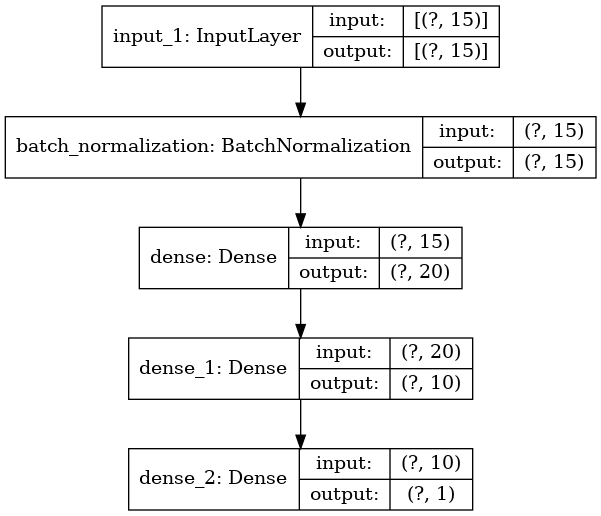

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Compile

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'Recall', 'Precision'],
    )

#### Make an EarlyStopping callback

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#### Fit the model

In [29]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size = 16,
                    epochs=50,
                    callbacks=[callback],
                    verbose=0)

#### Plot model performance on the validation data (accuracy, recall, and precision)

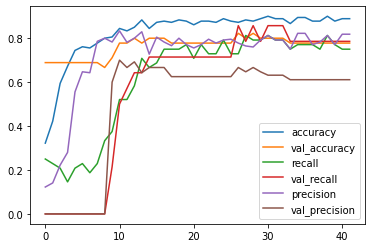

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.legend()

#### Save model

In [31]:
model.save('heart_1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: heart_1/assets


In [32]:
!pwd

/home/blue/general-assembly/dsir-824/submissions/labs/7.01-lab-nn-classification-master


#### Load model

In [33]:
reloaded = tf.keras.models.load_model('heart_1')

In [34]:
reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 15)                60        
_________________________________________________________________
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 601
Trainable params: 571
Non-trainable params: 30
_________________________________________________________________


#### Evaluate on test set 

In [35]:
reloaded.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.3117 - accuracy: 0.8553 - recall: 0.7619 - precision: 0.7273


[0.31172922253608704,
 0.8552631735801697,
 0.761904776096344,
 0.7272727489471436]

#### X_test predictions

In [36]:
preds = reloaded.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


#### What do those look like?

In [37]:
preds[:5]

array([[0],
       [0],
       [1],
       [0],
       [0]], dtype=int32)

#### How is the model performing? 
Let's look at the confusion matrix using TF.

In [38]:
tf.math.confusion_matrix(y_test, preds)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[49,  6],
       [ 5, 16]], dtype=int32)>

Or just use sklearn's confusion matrix. 

In [39]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, balanced_accuracy_score

In [40]:
confusion_matrix(y_test, preds)

array([[49,  6],
       [ 5, 16]])

#### Evaluate with other metrics

In [41]:
recall_score(y_test, preds)

0.7619047619047619

In [42]:
f1_score(y_test, preds)

0.7441860465116279

In [43]:
balanced_accuracy_score(y_test, preds)

0.8264069264069264

### Make a null model

In [44]:
y_test.value_counts(normalize=True)[0]

0.7236842105263158

## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [46]:
# lab time lab time lab time !!!!!!!

In [47]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_1,thal_2,thal_3
205,70,1,2,156,245,0,2,143,0,0.0,1,0,1,0,0
2,67,1,4,120,229,0,2,129,1,2.6,2,2,0,1,0
283,60,0,4,150,258,0,2,157,0,2.6,2,2,0,1,0
25,50,0,3,120,219,0,0,158,0,1.6,2,0,1,0,0
49,48,1,2,130,245,0,2,180,0,0.2,2,0,1,0,0


In [48]:
y_test.head()

78     0
46     0
259    1
157    0
285    0
Name: target, dtype: int64

In [49]:
# Notes: our first model looked like this:

# Batch Normalization
# Fully Connected Layer 15 -> 20
# Fully Connected Layer 20 -> 10
# Fully Connected Layer 10 -> 1
# Need to beat this model preformance

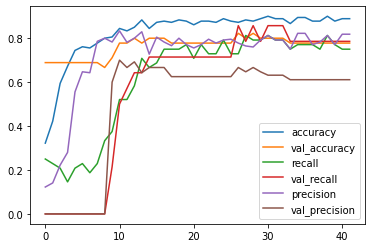

In [50]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.legend()

In [51]:
# Some model planning
# We have 15 inputs
# For fully connected networks:
# I want to do a 15, 10, 5, 1
# Then a 15, 30, 15, 1
# Then a 15, 10, 1
# 

In [52]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_1,thal_2,thal_3
205,70,1,2,156,245,0,2,143,0,0.0,1,0,1,0,0
2,67,1,4,120,229,0,2,129,1,2.6,2,2,0,1,0
283,60,0,4,150,258,0,2,157,0,2.6,2,2,0,1,0
25,50,0,3,120,219,0,0,158,0,1.6,2,0,1,0,0
49,48,1,2,130,245,0,2,180,0,0.2,2,0,1,0,0


In [53]:
y_train.head()

205    0
2      0
283    1
25     0
49     0
Name: target, dtype: int64

In [54]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [55]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 15)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 521
Trainable params: 491
Non-trainable params: 30
_________________________________________________________________


In [56]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'Recall', 'Precision'],
    )

In [57]:
history_1 = model_1.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size = 16,
                    epochs=50,
                    callbacks=[callback],
                    verbose=0)

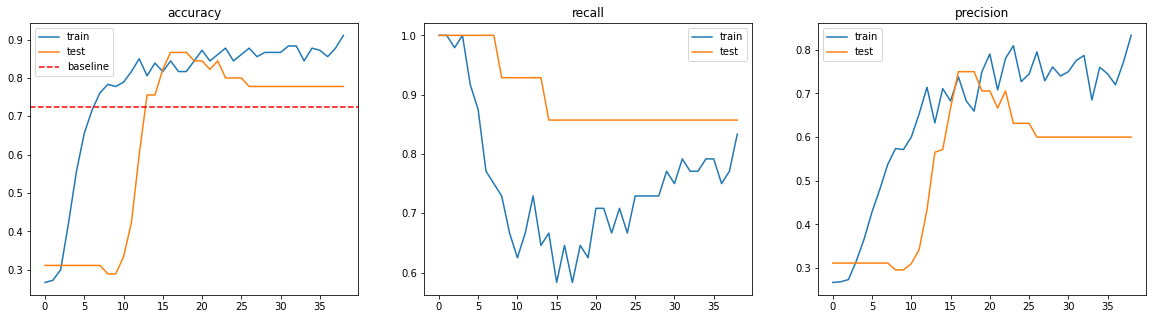

In [58]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(history_1.history['accuracy'], label='train')
plt.plot(history_1.history['val_accuracy'], label='test')
plt.axhline(.723, color='red', label='baseline', linestyle='--')
plt.title('accuracy')
plt.legend();
plt.subplot(1,3,2)
plt.plot(history_1.history['recall'], label='train')
plt.plot(history_1.history['val_recall'], label='test')
plt.title('recall')
plt.legend();
plt.subplot(1,3,3)
plt.plot(history_1.history['precision'], label='train')
plt.plot(history_1.history['val_precision'], label='test')
plt.title('precision')
plt.legend();

In [59]:
# hm, that's not too bad

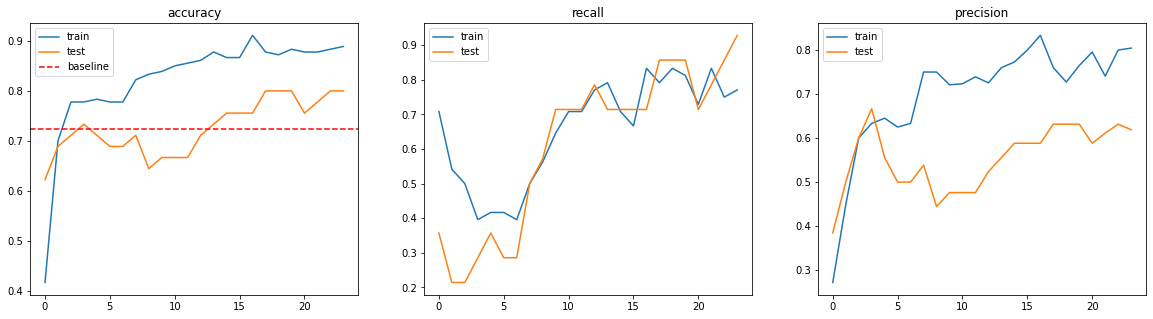

In [60]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'Recall', 'Precision'],
    )

history_2 = model_2.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size = 16,
                    epochs=50,
                    callbacks=[callback],
                    verbose=0)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(history_2.history['accuracy'], label='train')
plt.plot(history_2.history['val_accuracy'], label='test')
plt.axhline(.723, color='red', label='baseline', linestyle='--')
plt.title('accuracy')
plt.legend();
plt.subplot(1,3,2)
plt.plot(history_2.history['recall'], label='train')
plt.plot(history_2.history['val_recall'], label='test')
plt.title('recall')
plt.legend();
plt.subplot(1,3,3)
plt.plot(history_2.history['precision'], label='train')
plt.plot(history_2.history['val_precision'], label='test')
plt.title('precision')
plt.legend();

In [61]:
# Wow this is doing a lot better

In [62]:
# I've done this twice now, I'm making a function


model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'Recall', 'Precision'],
    )
    
def neural_net(model, epochs):
    tf.keras.backend.clear_session()
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        batch_size = 16,
                        epochs=epochs,
                        callbacks=[callback],
                        verbose=0)

    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.axhline(y_test.value_counts(normalize=True)[0], color='red', label='baseline', linestyle='--')
    y_max = max(history.history['val_accuracy'])
    x_max = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    plt.plot(x_max, y_max,'ro')
    plt.annotate(f'{x_max, round(y_max, 5)}', (x_max+.6, y_max+0.01))
    
    plt.title('accuracy')
    plt.legend();
    plt.subplot(1,3,2)
    plt.plot(history.history['recall'], label='train')
    plt.plot(history.history['val_recall'], label='test')
    plt.title('recall')
    plt.legend();
    plt.subplot(1,3,3)
    plt.plot(history.history['precision'], label='train')
    plt.plot(history.history['val_precision'], label='test')
    plt.title('precision')
    plt.legend();
    return history

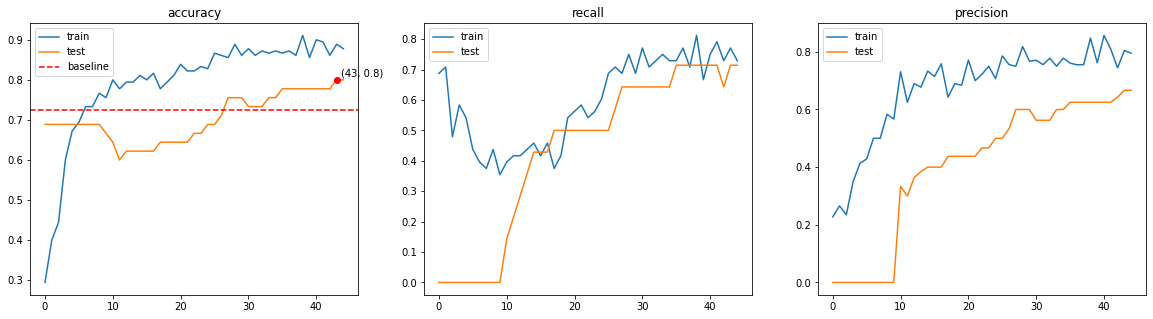

In [63]:
history_3 = neural_net(model_3, 50)

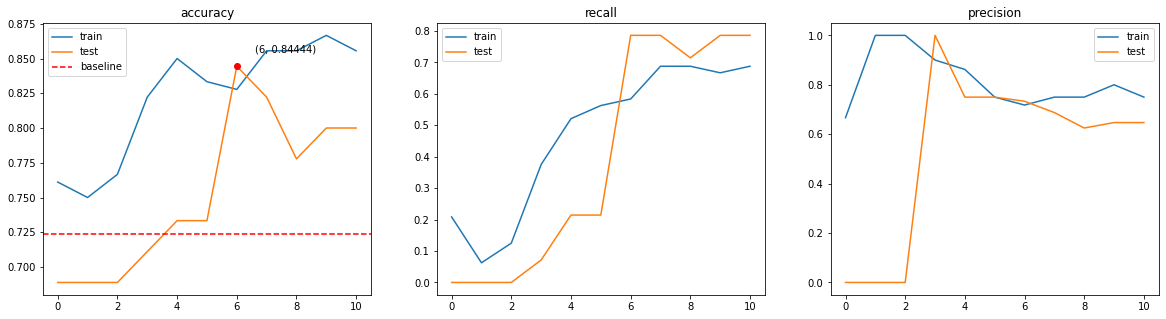

In [64]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])

model_4.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'Recall', 'Precision'],
    )

history_4 = neural_net(model_4, 50)

In [65]:
# This is a lot of models. Let's compare them all at a glance

In [66]:
histories = [history, history_2, history_3, history_4]

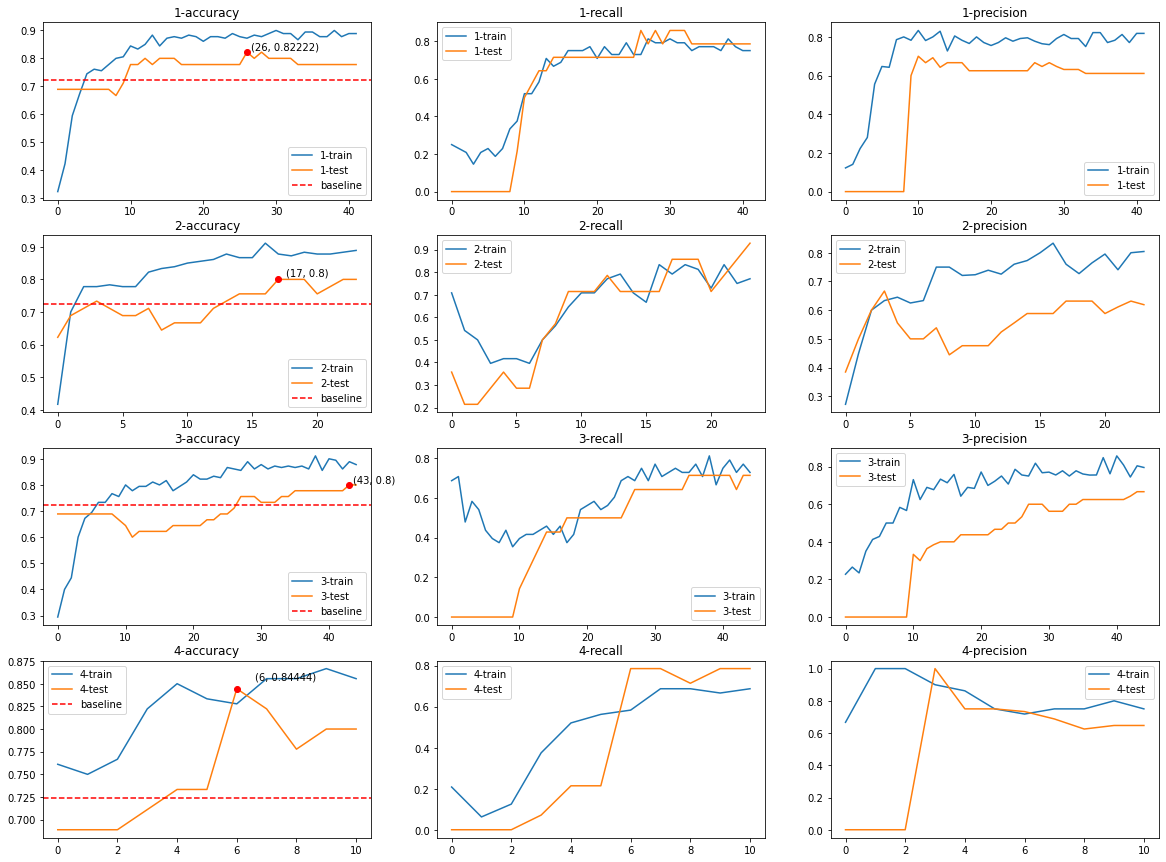

In [67]:
plt.figure(figsize=(20,15))
counter = 1
model_counter = 1
for i in histories:
    plt.subplot(4,3,counter)
    plt.plot(i.history['accuracy'], label=f'{model_counter}-train')
    plt.plot(i.history['val_accuracy'], label=f'{model_counter}-test')
    
    y_max = max(i.history['val_accuracy'])
    x_max = i.history['val_accuracy'].index(max(i.history['val_accuracy']))
    plt.plot(x_max, y_max,'ro')
    plt.annotate(f'{x_max, round(y_max, 5)}', (x_max+.6, y_max+0.01))
    
    plt.axhline(y_test.value_counts(normalize=True)[0], color='red', label='baseline', linestyle='--')
    plt.title(f'{model_counter}-accuracy')
    plt.legend();
    counter += 1
    
    plt.subplot(4,3,counter)
    plt.plot(i.history['recall'], label=f'{model_counter}-train')
    plt.plot(i.history['val_recall'], label=f'{model_counter}-test')
    plt.title(f'{model_counter}-recall')
    plt.legend();
    counter += 1
    
    plt.subplot(4,3,counter)
    plt.plot(i.history['precision'], label=f'{model_counter}-train')
    plt.plot(i.history['val_precision'], label=f'{model_counter}-test')
    plt.title(f'{model_counter}-precision')
    plt.legend();
    counter += 1
    model_counter += 1

In [68]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_5.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'Recall', 'Precision'],
    )

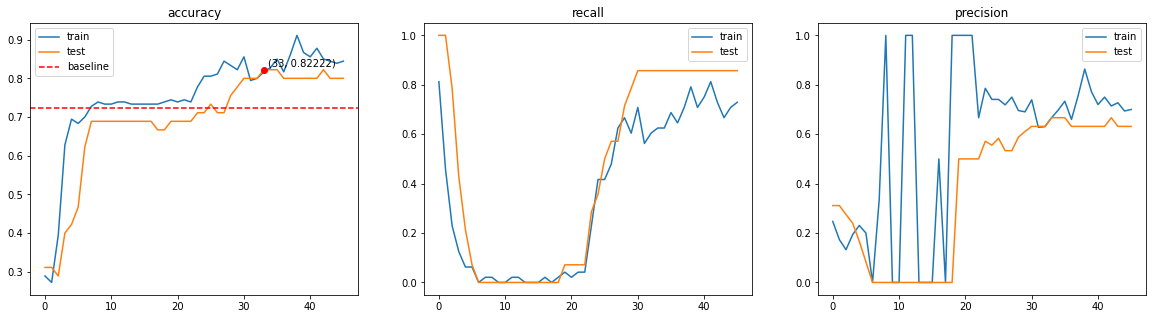

In [69]:
history_5 = neural_net(model_5, 100)

In [70]:
histories = [history, history_2, history_3, history_4, history_5]

In [ ]:
model_3.pre

In [ ]:
accuracy_score

In [162]:
predictions = []
baseline = []
for i in histories:
    preds = i.model.predict_classes(X_test)
    base = i.model.predict_classes(X_train)
    #rsme.append(mean_squared_error(y_test, preds, squared=False))
    predictions.append(accuracy_score(y_test, preds))
    baseline.append(accuracy_score(y_train, base))

In [124]:
# okay, i want one simple graph. let's use Accuracy

In [146]:
accuracy_score(y_test, model_5.predict_classes(X_test))

0.868421052631579

In [147]:
predictions

[0.8552631578947368,
 0.7894736842105263,
 0.8552631578947368,
 0.8552631578947368,
 0.868421052631579]

Text(0.5, 0, 'Higher is better')

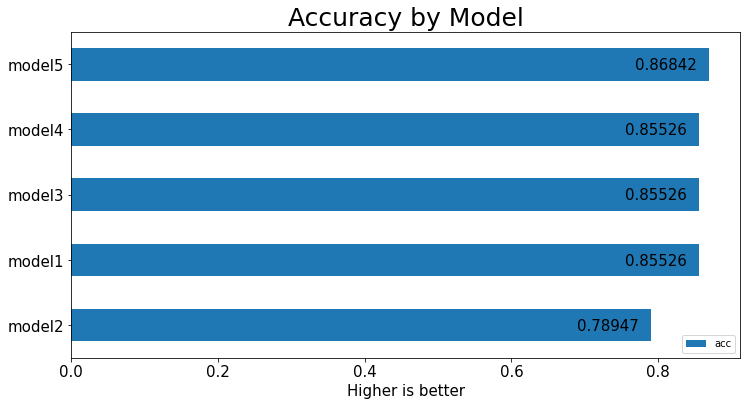

In [206]:
pd.DataFrame(predictions, index=['model1', 'model2', 'model3', 'model4', 'model5'], 
             columns=['acc']).sort_values(by='acc', ascending=True).plot(kind='barh', 
                                                                           figsize=(12,6),
                                                                           fontsize=15
                                                                          )
for i in list(enumerate(sorted(predictions))):
    plt.annotate(round(i[1],5),
                 (i[1] - 0.1, i[0] - 0.08),
                fontsize=15)
plt.title('Accuracy by Model', fontsize=25)
plt.xlabel('Higher is better', fontsize=15)

In [210]:
df_test_train = pd.DataFrame(zip(predictions, baseline), columns=['Test', 'Train'], index=['model1', 'model2', 'model3', 'model4', 'model5'])

In [211]:
df_test_train['% overfit'] = ((df_test_train['Train'] / df_test_train['Test']) - 1) * 100

In [212]:
df_test_train

,Test,Train,% overfit
model1,0.855263,0.866667,1.333333
model2,0.789474,0.875556,10.903704
model3,0.855263,0.875556,2.372650
model4,0.855263,0.848889,-0.745299
model5,0.868421,0.875556,0.821549


In [243]:
df_test_train['% overfit'].sort_values

<bound method Series.sort_values of model1     1.333333
model2    10.903704
model3     2.372650
model4    -0.745299
model5     0.821549
Name: % overfit, dtype: float64>

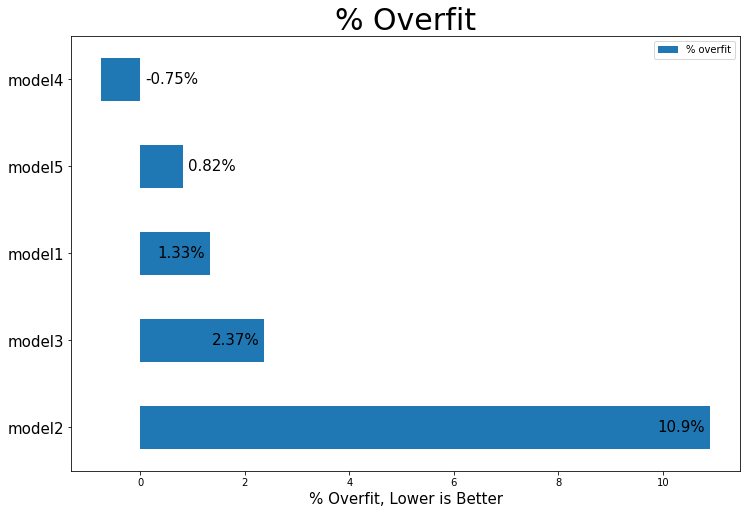

In [272]:
df_test_train[['% overfit']].sort_values(by='% overfit', ascending=False).plot(kind='barh', figsize=(12, 8))
plt.yticks(fontsize=15)
plt.xlabel('% Overfit, Lower is Better', fontsize=15)
plt.yticks(fontsize=15)
plt.title('% Overfit', fontsize=30);

for i in enumerate(df_test_train['% overfit'].sort_values(ascending=False)):
    plt.annotate(f'{round(i[1],2)}%',
                 ((0.1 if i[1] < 0 else i[1] + 0.1 if i[1] < 1 else i[1]-1), i[0]-0.05),
                fontsize=15)

#### Save your best model. 


In [152]:
model_5.save('acc-0.86842')

INFO:tensorflow:Assets written to: acc-0.86842/assets


#### Compare with other algorithms
Compare your best neural net model to a scikit-learn LogisticRegression model. Also try a GradientBoostingClassifier.

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

#### Scale and Standardize for Logistic Regression


In [140]:
ss = StandardScaler()

In [138]:
logr = LogisticRegression(n_jobs=-1)

In [141]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.fit_transform(X_test)

#### Logistic Regression

In [142]:
logr.fit(X_train_sc, y_train)

LogisticRegression(n_jobs=-1)

In [143]:
# Returns Mean Accuracy
logr.score(X_train_sc, y_train), logr.score(X_test_sc, y_test)

(0.88, 0.8289473684210527)

#### Evaluate performance on metrics other than accuracy

In [153]:
from sklearn.metrics import f1_score, classification_report

In [156]:
f1_score(y_train ,logr.predict(X_train_sc)), f1_score(y_test, logr.predict(X_test_sc))

(0.7768595041322315, 0.6976744186046512)

In [161]:
print(classification_report(y_test, logr.predict(X_test_sc)))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        55
           1       0.68      0.71      0.70        21

    accuracy                           0.83        76
   macro avg       0.79      0.79      0.79        76
weighted avg       0.83      0.83      0.83        76



### GradientBoosting

In [274]:
gb = GradientBoostingClassifier() # This is a decision tree, no need to standardize data

In [275]:
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [276]:
# Returns Mean Accuracy
gb.score(X_train, y_train), gb.score(X_test, y_test)

(1.0, 0.8157894736842105)

#### Evaluate performance on metrics other than accuracy

In [277]:
f1_score(y_train ,gb.predict(X_train)), f1_score(y_test, gb.predict(X_test))

(1.0, 0.6315789473684211)

In [278]:
print(classification_report(y_test, gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        55
           1       0.71      0.57      0.63        21

    accuracy                           0.82        76
   macro avg       0.78      0.74      0.75        76
weighted avg       0.81      0.82      0.81        76



#### Which evaluation metric(s) are best to use in this problem?

In [281]:
y.value_counts(normalize=True)

0    0.724252
1    0.275748
Name: target, dtype: float64

In [282]:
# In this case, it would be smart to to a balanced accuracy store because of the imbalance of classified items

In [ ]:
classification_report

In [284]:
# From classification report, weighted average is the support weighted mean per label
# NOTE:
'''
Calculate metrics for each label, and find their average weighted by support 
(the number of true instances for each label). This alters ‘macro’ to account 
for label imbalance; it can result in an F-score that is not between precision and recall.
''';

#### Which model would you recommend for use? Why?

In [285]:
# I would use a combination of the neural net and the logistic regression in an esnemble style estimator like a voting classifier because each one has their strengths and I 
# think having both would be more powerful

# in the case of choosing only one, if the project requires something quick for gudance, I would use logistic regression and write the report that day

# if the client wants more introspection, then I would look at levergaging neural nets for more insight because that would be a larger investment of my time as a data scientist


#### Download your notebook and put it in your submission folder. 🎉